<a href="https://colab.research.google.com/github/tony3ynot/DDPM_and_DDIM/blob/main/DDPM_%26_DDIM_on_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from einops import rearrange
import math

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import time

from tqdm.auto import tqdm
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available() else "cpu"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. DDPM

Implementation of DDPM ([Ho, et al., "Denoising Diffusion Probabilistic Models", 2020.](https://arxiv.org/abs/2006.11239))

## 1-1. U-Net Architecture

You can just simply import from diffusers!

In [10]:
from diffusers import UNet2DModel

model = UNet2DModel(in_channels=3, out_channels=3, block_out_channels=(32, 64, 128, 128))

Or you can implement from the scratch like below.

[Reference code 1](https://github.com/w86763777/pytorch-ddpm/blob/master/model.py)

[Reference code 2](https://github.com/CodingVillainKor/SimpleDeepLearning/blob/main/DDPM_notebook.ipynb)

In [11]:
## Sinusoidal time embedding (similar to Transformer)
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.layer1 = nn.Linear(dim // 4, dim)
        self.silu = nn.SiLU()
        self.layer2 = nn.Linear(dim, dim)

    def forward(self, time):
        half_dim = self.dim // 8
        emb = math.log(10000) / (half_dim-1)
        emb = torch.exp(torch.arange(half_dim, device=time.device) * -emb)
        emb = time[:,None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        emb = self.silu(self.layer1(emb))
        emb = self.layer2(emb)
        return emb


## Residual Block w/ Group Normalization
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, group_num = 32, dropout = 0.1):
        super().__init__()
        self.silu = nn.SiLU()
        self.dropout = nn.Dropout(dropout)

        self.norm1 = nn.GroupNorm(group_num, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)

        self.norm2 = nn.GroupNorm(group_num, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x, time):
        h = self.conv1(self.silu(self.norm1(x)))
        h += self.time_emb(self.silu(time))[:, :, None, None]
        h = self.conv2(self.dropout(self.silu(self.norm2(h))))

        out = h + self.shortcut(x)
        return out


## Attention Block (similar to Multi-Head Attention)
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, n_heads=1, d_k=None, group_num=32):
        super().__init__()
        self.n_heads = n_heads

        if d_k is None: # Head Dimension
            self.d_k = in_channels
        else:
            self.d_k = d_k

        self.norm = nn.GroupNorm(group_num, in_channels)

        self.fc_q = nn.Linear(in_channels, in_channels)
        self.fc_k = nn.Linear(in_channels, in_channels)
        self.fc_v = nn.Linear(in_channels, in_channels)
        self.fc = nn.Linear(in_channels, in_channels)

        self.scale = self.d_k ** -0.5

    def forward(self, x):
        # b = batch size / c = in_channels / h = height / w = width
        b, c, h, w = x.shape
        qkv = self.norm(x) # [b, c, h, w]
        qkv = rearrange(qkv, 'b c h w -> b (h w) c') # [b, h*w, c]

        Q = self.fc_q(qkv)
        K = self.fc_k(qkv)
        V = self.fc_v(qkv)

        # L = h*w / H = heads / D = dimension
        Q = rearrange(Q, 'b L (H D) -> b H L D', H = self.n_heads)
        K = rearrange(K, 'b L (H D) -> b H L D', H = self.n_heads)
        V = rearrange(V, 'b L (H D) -> b H L D', H = self.n_heads)

        attn = Q @ K.transpose(-2, -1)
        attn = attn * self.scale
        attn = torch.softmax(attn, dim=-1)
        attn = attn @ V

        res = rearrange(attn, 'b H L D -> b L (H D)') # [b, h*w, c]
        res = self.fc(res)
        res = rearrange(res, 'b (h w) c -> b c h w', h = h, w = w)
        out = res + x
        return out


## Down Sampling by 1/2x
class DownSample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, 3, stride=2, padding=1)

    def forward(self, x, time):
        x = self.conv(x)
        return x


## Up Sampling by 2x
class UpSample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor = 2, mode = 'nearest')
        self.conv = nn.Conv2d(in_channels, in_channels, 3, stride=1, padding=1)

    def forward(self, x, time):
        x = self.conv(self.up(x))
        return x


## Down Block in U-Net
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, attn=False):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if attn:
           self.attn = AttentionBlock(out_channels)
        else:
           self.attn = nn.Identity()

    def forward(self, x, time):
        x = self.res(x, time)
        x = self.attn(x)
        return x


## Middle Block in U-Net
class MiddleBlock(nn.Module):
    def __init__(self, in_channels, time_channels):
        super().__init__()
        self.res1 = ResidualBlock(in_channels, in_channels, time_channels)
        self.attn = AttentionBlock(in_channels)
        self.res2 = ResidualBlock(in_channels, in_channels, time_channels)

    def forward(self, x, time):
        x = self.res1(x, time)
        x = self.attn(x)
        x = self.res2(x, time)
        return x


## Up Block in U-Net
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, attn=False):
        super().__init__()
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if attn:
           self.attn = AttentionBlock(out_channels)
        else:
           self.attn = nn.Identity()

    def forward(self, x, time):
        x = self.res(x, time)
        x = self.attn(x)
        return x

In [12]:
## U-Net Architecture
class UNet(nn.Module):
    def __init__(self, img_channels=3, n_channels=32, expansion=(1, 2, 2, 1), attn=(False, False, True, True), n_blocks=2):
        super().__init__()
        n_resolutions = len(expansion)

        self.conv1 = nn.Conv2d(img_channels, n_channels, 3, padding=1)
        self.time_emb = SinusoidalTimeEmbedding(n_channels*4)

        # down sampling (encoder)
        down = []
        out_channels = in_channels = n_channels
        for i in range(n_resolutions):
            out_channels = in_channels * expansion[i]
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels*4, attn[i]))
                in_channels = out_channels
            if i < n_resolutions - 1:
                down.append(DownSample(in_channels))
        self.down_layers = nn.Sequential(*down)

        # connection
        self.middle_layers = MiddleBlock(out_channels, n_channels*4)

        # up sampling (decoder)
        up = []
        in_channels = out_channels
        for i in reversed(range(n_resolutions)):
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels*4, attn[i]))
            out_channels = in_channels // expansion[i]
            up.append(UpBlock(in_channels, out_channels, n_channels*4, attn[i]))
            in_channels = out_channels
            if i > 0:
                up.append(UpSample(in_channels))
        self.up_layers = nn.Sequential(*up)

        self.norm = nn.GroupNorm(8, in_channels)
        self.silu = nn.SiLU()
        self.conv2 = nn.Conv2d(in_channels, img_channels, 3, padding=1)

    def forward(self, x, time):
        x = self.conv1(x)
        t = self.time_emb(time)

        res = [x]

        for layer in self.down_layers:
            x = layer(x, t)
            res.append(x)

        x = self.middle_layers(x, t)

        for layer in self.up_layers:
            if isinstance(layer, UpSample):
                x = layer(x, t)
            else:
                skip = res.pop()
                x = torch.cat((x,skip), dim=1)
                x = layer(x, t)

        out = self.conv2(self.silu(self.norm(x)))
        return out

In [13]:
model2 = UNet().to(device)
x = torch.rand([2,3,32,32]).to(device)
t = torch.rand(1).to(device)
model2(x, t).shape

torch.Size([2, 3, 32, 32])

## 1-2. DDPM Training & Sampling
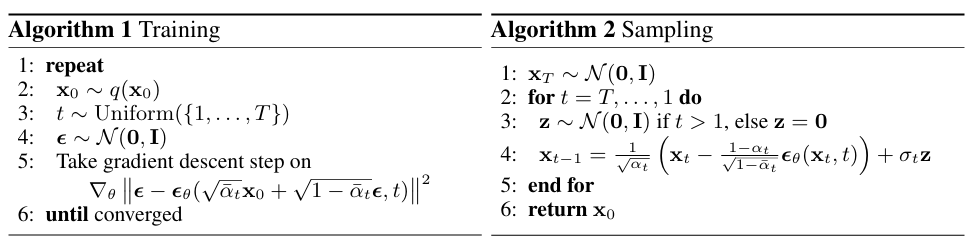

- Training Function


In [14]:
T_steps = 1000
beta = torch.linspace(1e-4, 0.02, T_steps).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
alpha_bar_prev = torch.cat([torch.tensor([1.0], device=device), alpha_bar[:-1]])
sigma2 = (1 - alpha_bar_prev) / (1 - alpha_bar) * beta

def gather(coeff, t, x):
    B, *dims = x.shape
    out = torch.gather(coeff, index=t, dim=0)
    return out.view([B] + [1]*len(dims))

## DDPM Loss Function (Training)
def ddpm_loss(model, x_0):
    t = torch.randint(T_steps, size=(x_0.shape[0], ), device=x_0.device)

    # sample x_t
    mu = gather(alpha_bar, t, x_0)**0.5 * x_0
    var = 1 - gather(alpha_bar, t, x_0)
    eps = torch.randn_like(x_0) # Gaussian noise
    x_t = mu + var**0.5 * eps

    eps_theta = model(x_t, t)

    loss = F.mse_loss(eps_theta, eps)
    return loss

- Inference (Sampling) Function

In [15]:
# DDPM Sampling
def sample(model, x_T):
    x_t = x_T
    for step in reversed(range(T_steps)):
        t = torch.full((x_T.shape[0],), step, device=device)
        eps_theta = model(x_t, t) # predict noise

        coef = beta / (1 - alpha_bar)**0.5
        mu = gather(1. / alpha**0.5, t, eps_theta) * (x_t - gather(coef, t, eps_theta)*eps_theta)
        var = gather(sigma2, t, eps_theta)
        z = torch.randn_like(x_t) if step else 0 # Gaussian noise (except last step)

        x_t = mu + (var**0.5) * z # sample x_{t-1}
    x_0 = x_t
    return x_0

- Training on CIFAR-10 images

In [ ]:
dataset = datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

epochs = 20
model = UNet(n_channels=32).to(device)
#model = UNet2DModel(in_channels=3, out_channels=3, block_out_channels=(32, 64, 128, 128)).to(device)
optim = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)

100%|██████████| 170M/170M [00:18<00:00, 9.19MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.081]
> Epoch 0 Samples


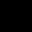

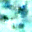

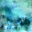

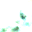

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.030]
> Epoch 1 Samples


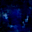

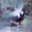

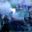

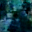

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.034]
> Epoch 2 Samples


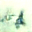

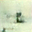

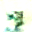

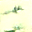

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.012]
> Epoch 3 Samples


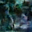

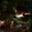

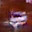

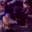

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.063]
> Epoch 4 Samples


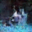

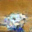

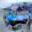

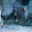

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.016]
> Epoch 5 Samples


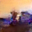

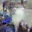

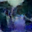

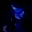

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.051]
> Epoch 6 Samples


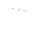

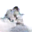

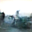

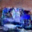

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.012]
> Epoch 7 Samples


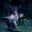

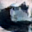

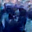

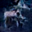

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.016]
> Epoch 8 Samples


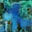

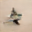

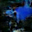

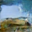

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.012]
> Epoch 9 Samples


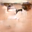

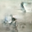

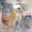

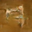

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.019]
> Epoch 10 Samples


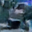

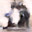

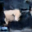

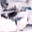

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.011]
> Epoch 11 Samples


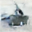

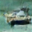

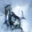

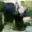

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.017]
> Epoch 12 Samples


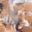

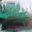

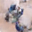

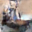

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.010]
> Epoch 13 Samples


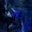

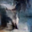

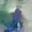

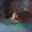

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.036]
> Epoch 14 Samples


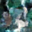

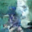

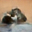

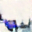

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.022]
> Epoch 15 Samples


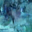

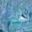

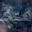

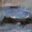

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.024]
> Epoch 16 Samples


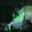

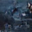

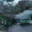

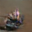

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.013]
> Epoch 17 Samples


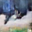

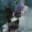

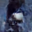

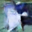

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.009]
> Epoch 18 Samples


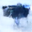

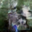

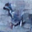

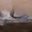

  0%|          | 0/1563 [00:00<?, ?it/s]

[Epoch: 1563 , Loss: 0.059]
> Epoch 19 Samples


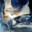

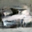

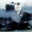

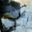

In [ ]:
for epoch in range(epochs):
    model.train()
    for i, (x, _) in enumerate(tqdm(dataloader)):
        optim.zero_grad()
        img = x.to(device)
        loss = ddpm_loss(model, img)
        loss.backward()
        optim.step()
        print("\r[Epoch: {} , Loss: {:.3f}]".format(i+1, loss.item()), end='')
    scheduler.step()

    # sampling images every epoch
    print("\n> Epoch {} Samples".format(epoch))
    model.eval()
    with torch.no_grad():
        x_T = torch.randn(4, 3, 32, 32).to(device)
        x_0 = sample(model, x_T)
        x_0 = x_0.permute(0, 2, 3, 1).clamp(0, 1).detach().cpu().numpy() * 255
        for i in range(4):
            cv2_imshow(x_0[i])

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/results/ddpm_model.pth")

- Sampling Experiment (+ Inference Time Check)

<ipython-input-21-f012e2f21052>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/results/ddpm_model.

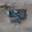

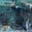

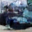

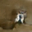

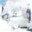

Inference Time: 7m 27.65s


In [ ]:
DDPM_model = UNet(n_channels=32).to(device)
DDPM_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/results/ddpm_model.pth'))

## Check inference time for 1000 samples
start_time = time.time()

with torch.no_grad():
    x_T = torch.randn(1000, 3, 32, 32).to(device)
    x_0 = sample(DDPM_model, x_T)
    x_0 = x_0.permute(0, 2, 3, 1).clamp(0, 1).detach().cpu().numpy() * 255
    for i in range(5):
        cv2_imshow(x_0[i])

end_time = time.time()
elapsed_time = end_time - start_time
min, sec = divmod(elapsed_time, 60)

print(f"Inference Time: {int(min)}m {sec:.2f}s")

# 2. DDIM
Implementation of DDIM sampler ([Song, et al., "Denoising Diffusion Implicit Models", 2022.](https://arxiv.org/abs/2010.02502))

- Inference (Sampling) Function

Since the training loss is proved to be same with DDPM, we can omit the training process and just use pre-trained model.
We only need to implement "accelerated generation process".

Here we set $\eta=0.0$, for 'pure' DDIM.

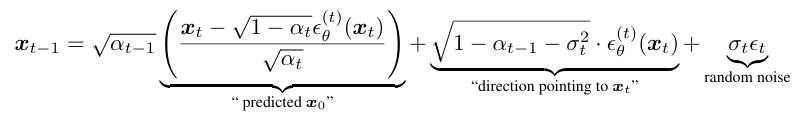
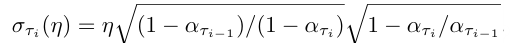

In [16]:
T_steps = 1000
beta = torch.linspace(1e-4, 0.02, T_steps).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
alpha_bar_prev = torch.cat([torch.tensor([1.0], device=device), alpha_bar[:-1]])

# DDIM Sampling
def fast_sample(model, x_T, steps, eta=0.0):
    tau_steps = np.linspace(0, T_steps - 1, steps, dtype=int)  # smaller sampling trajectory length
    # match with new sampling steps
    ddim_alpha = alpha_bar[tau_steps]
    ddim_alpha_prev = torch.cat([torch.tensor([1.0], device=device), alpha_bar[tau_steps[:-1]]])
    ddim_sigma = eta * ((1 - ddim_alpha_prev) / (1 - ddim_alpha) * (1 - ddim_alpha / ddim_alpha_prev))**0.5

    x_t = x_T
    for step in reversed(range(len(tau_steps))):
        t = torch.full((x_T.shape[0],), tau_steps[step], device=device, dtype=torch.long)
        eps_theta = model(x_t, t)
        sigma = ddim_sigma[step]
        eps = torch.randn_like(x_t) if step > 0 else 0

        pred_x0 = (x_t - (1 - ddim_alpha[step])**0.5 * eps_theta) / (ddim_alpha[step]**0.5)
        dir_xt = (1 - ddim_alpha_prev[step] - sigma**2)**0.5 * eps_theta
        noise = sigma * eps

        x_t = ddim_alpha_prev[step]**0.5 * pred_x0 + dir_xt + noise  # sample x_{t-1}
    x_0 = x_t
    return x_0

- Sampling Experiment (+ Inference Time Check)

See how DDIM sampler is much faster than DDPM, while retaining sample qualities.

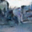

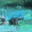

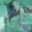

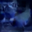

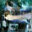

Inference Time: 0m 23.37s


In [39]:
## Use same model
DDIM_model = UNet(n_channels=32).to(device)
DDIM_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/results/ddpm_model.pth'))

## Check inference time for 1000 samples
start_time = time.time()

with torch.no_grad():
    x_T = torch.randn(1000, 3, 32, 32).to(device)
    x_0 = fast_sample(DDIM_model, x_T, steps=50, eta=0.0)
    x_0 = x_0.permute(0, 2, 3, 1).clamp(0, 1).detach().cpu().numpy() * 255
    for i in range(5):
        cv2_imshow(x_0[i])

end_time = time.time()
elapsed_time = end_time - start_time
min, sec = divmod(elapsed_time, 60)

print(f"Inference Time: {int(min)}m {sec:.2f}s")

# DDPM vs DDIM

Obviously, DDIM is much faster than DDPM in sampling process. Here, we discover another beautiful feature of DDIM, 'consistency'.

Given same latent space $x_T$, DDIM can generate same result $x_0$ everytime, unlike DDPM.

DDPM Generation 1:


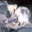

Generation completed.
DDPM Generation 2:


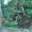

Generation completed.
DDPM Generation 3:


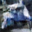

Generation completed.


In [27]:
# Sample an image 3 times (DDPM)
with torch.no_grad():
    x_T = torch.randn(1, 3, 32, 32).to(device)  # initial latent space
    for i in range(3):
        print(f"DDPM Generation {i+1}:")
        x_0 = sample(DDPM_model, x_T)
        x_0 = x_0.permute(0, 2, 3, 1).clamp(0, 1).detach().cpu().numpy() * 255
        cv2_imshow(x_0[0])
        print("Generation completed.")

DDIM Generation 1:


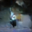

Generation completed.
DDIM Generation 2:


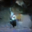

Generation completed.
DDIM Generation 3:


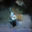

Generation completed.


In [32]:
# Sample an image 3 times (DDIM)
with torch.no_grad():
    x_T = torch.randn(1, 3, 32, 32).to(device)  # initial latent space
    for i in range(3):
        print(f"DDIM Generation {i+1}:")
        x_0 = fast_sample(DDIM_model, x_T, steps=100, eta=0.0)
        x_0 = x_0.permute(0, 2, 3, 1).clamp(0, 1).detach().cpu().numpy() * 255
        cv2_imshow(x_0[0])
        print("Generation completed.")

Interestingly, when we slightly increase $\eta$, the samples have variances.

DDIM Generation 1:


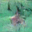

Generation completed.
DDIM Generation 2:


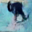

Generation completed.
DDIM Generation 3:


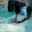

Generation completed.


In [35]:
# Sample an image 3 times (DDIM)
with torch.no_grad():
    x_T = torch.randn(1, 3, 32, 32).to(device)  # initial latent space
    for i in range(3):
        print(f"DDIM Generation {i+1}:")
        x_0 = fast_sample(DDIM_model, x_T, steps=100, eta=0.2)
        x_0 = x_0.permute(0, 2, 3, 1).clamp(0, 1).detach().cpu().numpy() * 255
        cv2_imshow(x_0[0])
        print("Generation completed.")